# Import

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
import itertools

import os

import xgboost as xgb 
from xgboost import plot_importance , XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from keras.utils.np_utils import to_categorical 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *

from tqdm import tqdm, notebook
import time

# Read Data

In [2]:
train_original = pd.read_csv('./open data/train.csv')
test_original = pd.read_csv('./open data/test_x.csv')
train = train_original.copy()
test = test_original.copy()

In [3]:
# fill NA
def fill_married(data):
    pdata = data.copy()
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='10s'),'married' ] = 1
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='20s'),'married' ] = 1
    pdata.loc[pdata.married==0,'married'] = 2
    
    return pdata

def fill_education(data):
    pdata = data.copy()
    pdata.loc[(pdata.education==0)&(pdata.age_group=='10s'),'education'] = 2
    pdata.loc[pdata.education==0,'education'] = 3

    return pdata

def fill_engnat(data):
    pdata = data.copy()
    pdata.loc[pdata.engnat==0,'engnat'] = 1
    
    return pdata

def fill_hand(data):
    pdata = data.copy()
    pdata.loc[pdata.hand==0,'hand'] = 1
    
    return pdata
# feature engineering
def Mach_score(data):
    pdata = data.copy()
    Answers = []
    for i in range(20):
        Answers.append('Q'+chr(97+i)+'A')
    reverse_col = ['QeA','QfA','QkA','QqA','QrA','QaA','QdA','QgA','QiA','QnA']
    for col in reverse_col:
        pdata[col] = -pdata[col]
    pdata['Mach_score'] = pdata[Answers].sum(axis=1)
    
    return pdata

def w_score(data):
    pdata = data.copy()
    wr = []
    wf = []
    for i in range(1,14):
        wr.append(f'wr_{i:02d}')
    for i in range(1,4):
        # pdata[f'wf_{i:02d}'] = -pdata[f'wf_{i:02d}']
        wf.append(f'wf_{i:02d}')
    
    pdata['wr'] = pdata[wr].sum(axis=1)
    pdata['wf'] = pdata[wf].sum(axis=1)
    
    return pdata

def TIPI(data):
    pdata = data.copy()
    pdata['tp_score_1'] = pdata['tp01'] - pdata['tp06']
    pdata['tp_score_2'] = pdata['tp07'] - pdata['tp02']
    pdata['tp_score_3'] = pdata['tp03'] - pdata['tp08']
    pdata['tp_score_4'] = pdata['tp09'] - pdata['tp04']
    pdata['tp_score_5'] = pdata['tp05'] - pdata['tp10']
    
    return pdata

# drop outlier
def drop_outlier(data, datatype):
    
    assert datatype == 'train' or datatype=='test', 'Wrong data type given'
    
    pdata = data.copy()
    if datatype=='train':
        
        out_arr = []
        out_arr.append( np.where(data['familysize']>=16)[0] )
        out_arr.append( np.where(data.wr<=3)[0] )
        out_arr.append( np.where(data.wf>=2)[0] )

        out = []
        for outarr in out_arr:
            out = np.union1d(out, outarr)

        pdata = data.drop(out)
    
    return pdata
# feature banding
def age_band(data):
    pdata = data.copy()
    pdata['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,5,5],inplace=True)
    
    return pdata

def E_band(data, num_band):
    pdata = data.copy()
    for i in range(20):
        col = 'Q'+chr(i+97)+'E'
        pdata[col] = pd.qcut(pdata[col],num_band)
        unique = pdata[col].unique()
        pdata[col].replace(unique,range(num_band),inplace=True)
        
    return pdata

def family_band(data):
    pdata = data.copy()
    pdata.loc[pdata.familysize >= 4,'familysize'] = 4
    
    return pdata
# categorical value to numerical value
def cat_gender(data):
    feature = 'gender'
    pdata = data.copy()
    pdata[feature].replace(['Male','Female'],[0,1],inplace=True)
    
    return pdata

def cat_race(data):
    feature = 'race'
    pdata = data.copy()
    unique = ['White', 'Asian', 'Other', 'Black', 'Native American', 'Arab', 'Indigenous Australian']
    pdata[feature].replace(unique,[0,1,2,3,2,2,2],inplace=True)
    
    return pdata

def cat_religion(data):
    feature = 'religion'
    pdata = data.copy()
    unique = ['Other', 'Hindu', 'Agnostic', 'Atheist', 'Christian_Other',
       'Christian_Catholic', 'Muslim', 'Buddhist', 'Christian_Protestant',
       'Jewish', 'Christian_Mormon', 'Sikh']
    pdata[feature].replace(unique,[3,3,1,0,2,2,3,3,2,3,3,3],inplace=True)
    
    return pdata

def cat_num(data):
    pdata = data.copy()
    pdata = cat_gender(pdata)
    pdata = cat_race(pdata)
    pdata = cat_religion(pdata)
    
    return pdata
# drop feature
def drop_feature(data):
    feature_arr = ['index'] 
    for i in range(20):
        feature_arr.append('Q'+chr(i+97)+'A')
    for i in range(1,14):
        feature_arr.append(f'wr_{i:02d}')
    for i in range(1,4):
        feature_arr.append(f'wf_{i:02d}')
    for i in range(1,11):
        feature_arr.append(f'tp{i:02d}')
    for i in range(20):
        feature_arr.append('Q'+chr(i+97)+'E')

    pdata = data.drop(feature_arr,axis=1)
    
    return pdata


In [4]:
def preprocess(data, datatype):
    
    pdata = data.copy()
    # fill NA
    pdata = fill_married(pdata)
    pdata = fill_education(pdata)
    pdata = fill_engnat(pdata)
    pdata = fill_hand(pdata)
    # feature engineering
    pdata = Mach_score(pdata)
    pdata = w_score(pdata)
    pdata = TIPI(pdata)
    # drop outlier
    pdata = drop_outlier(pdata,datatype)
    # feature banding
    pdata = age_band(pdata)
    pdata = family_band(pdata)
    pdata = E_band(pdata,10)
    # categorical value to numerical value
    pdata = cat_num(pdata)
    # drop feature
    pdata = drop_feature(pdata)
    # unify type of data
    pdata = pdata.astype(np.int)
    
    return pdata

In [5]:
def submission(test_data, model_arr,file_name):
    score = np.zeros((test_data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(test_data)
    pred = np.divide(score,num_model)[:,1]
    data = {'index':test['index'],'voted':pred}
    submission = DataFrame(data)
    submission.to_csv('./submission/'+file_name+'.csv',index=False)
    
    return pred

In [6]:
def train_auc(model_arr, data, label):
    score = np.zeros((data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(data)
    pred = np.divide(score,num_model)[:,1]
    
    return roc_auc_score(label, pred)

# KFold 

# XGBoost

In [7]:
def xgb_pred(max_depth=5, n_estimators=500, learning_rate=0.02, min_child=3):
    
    train_x = preprocess(train,'train')
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test')
    
    param = { 'max_depth' : max_depth,
            'n_estimators' : n_estimators,
            'learning_rate' : learning_rate,
             'min_child_weight' : min_child,
            'verbosity' : 0,
            'objective' : 'binary:logistic',
            'booster' : 'gbtree',
            'subsample' : 0.8,
            'colsample_bytree' : 0.8}

    model = XGBClassifier(**param)
    
    start_train = time.time()
    model.fit(train_x,train_y, verbose=False)
    print(f'Training : {time.time()-start_train:.2f}s')
    
    print(f'{max_depth}_{n_estimators}_{learning_rate:.3f}_{min_child} : ', end=' ')
    pred_auc = train_auc([model], train_x, train_y)
    print(f'{pred_auc:.4f}')
    file_name = f'xgb_pred_{max_depth}_{n_estimators}_{learning_rate:.3f}_{min_child}_{pred_auc:.4f}'
    submission(test_x,[model],file_name)
    
    return model

In [8]:
model1 = xgb_pred(max_depth=7, n_estimators=300, learning_rate=0.012,min_child=16)

Training : 3.50s
7_300_0.012_16 :  0.7923


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

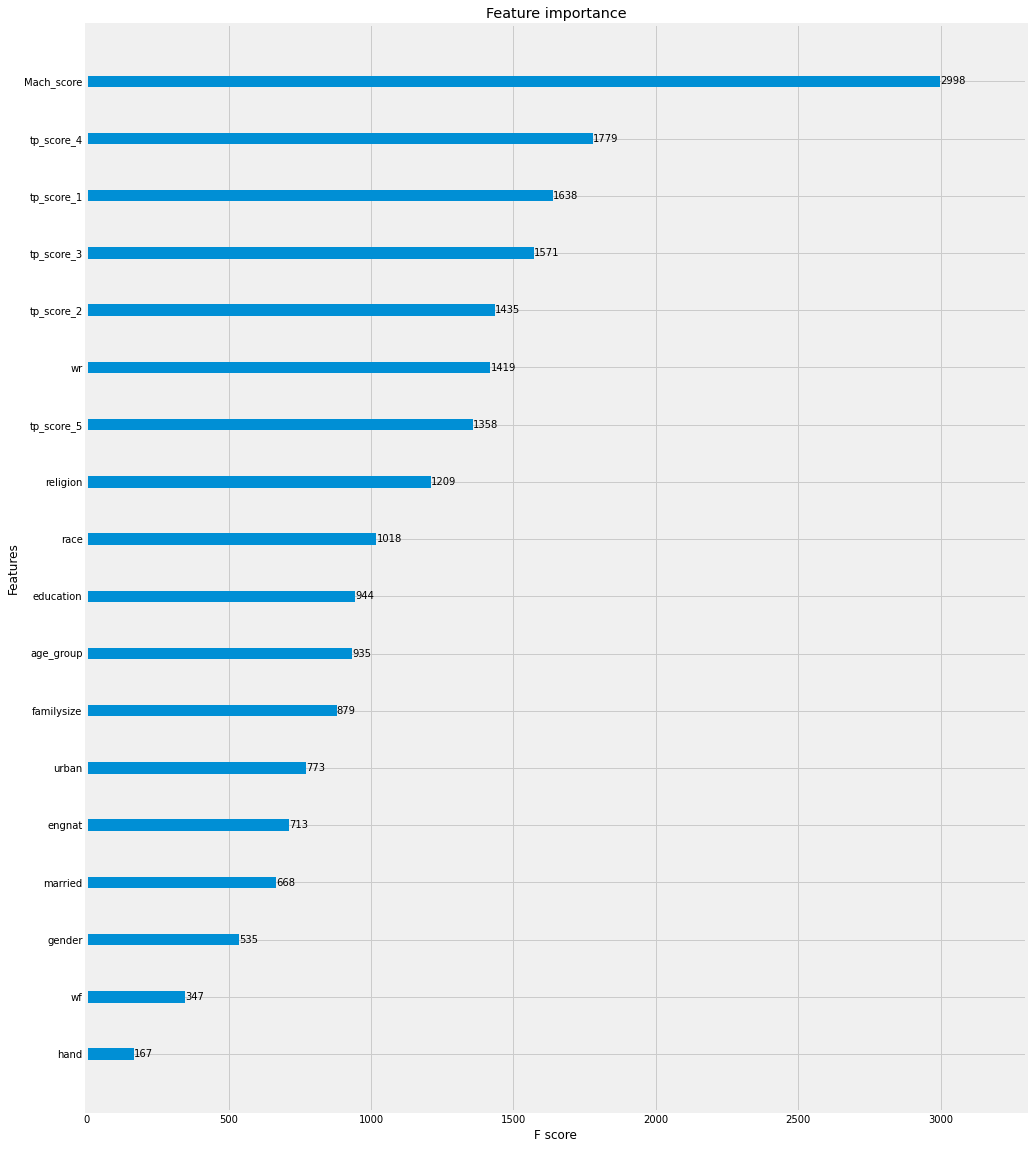

In [9]:
fig, ax = plt.subplots(figsize=(15,20))
plot_importance(model1, ax=ax)

# LightGBM

In [54]:
def lgbm(n_estimators=200, min_child=1000, subsample=0.7):

    train_x = drop_outlier(train)
    train_x = preprocess(train_x)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test)


    model = LGBMClassifier(boosting_type='rf', num_leaves=60, max_depth=-1, 
                           n_estimators=n_estimators, min_child_samples=min_child, subsample=0.7, subsample_freq=1, objective='binary')
    model.fit(train_x,train_y, eval_metric='auc')


    submission(test_x,[model],f'lgbm_{n_estimators}_{min_child}_{subsample}')
    print( train_auc([model],train_x,train_y) )
    
    return model

In [55]:
model2 = lgbm()

0.7567122901530732


In [14]:
def plot_heatmap(data,feature,mode):
    
    fig, ax = plt.subplots(figsize=(15,15))
    corr = data.corr()
    
    if mode=='large':
        cols = corr.nlargest(10,feature)[feature].index
    elif mode=='small':
        cols_s = corr.nsmallest(9,feature)[feature].index
        cols_l = corr.nlargest(1,feature)[feature].index
        cols = cols_l.append([cols_s])
    else : 
        cols_s = corr.nsmallest(5,feature)[feature].index
        cols_l = corr.nlargest(6,feature)[feature].index
        cols = cols_l.append([cols_s])
        
    cm = np.corrcoef(data[cols].values.T)
    sns.set(font_scale=1.25)
    sns.heatmap(cm,cbar=True,annot=True, square=True, fmt='.2f', annot_kws={"size":10}, yticklabels=cols.values,xticklabels=cols.values,cmap='Blues', ax=ax)
    
    return cols